In [1]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import datetime
from helper import get_cat_count, count_parameters, compute_confusion_matrix, show_examples, plot_training_loss, plot_accuracy, plot_confusion_matrix

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [2]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                # transforms.RandomCrop((64, 64)),
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.55, 1.0), ratio=(0.75, 1.3)),
                transforms.RandomHorizontalFlip(),
                transforms.RandomPerspective(p=0.2),
                transforms.RandomAffine(degrees=(-15, 15), translate=(0.0, 0.5)),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.1, hue=0.02),
                transforms.RandomPosterize(bits=3, p=0.3),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.01),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
                ## T.RandomErasing(),
                ## T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
                ## T.RandomInvert(p=0.05),
                transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                # transforms.CenterCrop((64, 64)),
                transforms.ToTensor()
                ## Standardize each channel of the image
                ## transforms.Normalize([0.485, 0.456, 0.406],
                ##                                 [0.229, 0.224, 0.225]),
            ]
        )

In [3]:
#################################################################################
#####                      Specify NN to be used                           ######
#################################################################################

### Simplified implementation of VGG16 with 12 layers instead of 16.
### Cut layer = 256 - 256 conv layer. 512-512 * 3 conv layers at the end.
### Reduced number of nodes on FC layer from 4096 to 1024.
vgg_12 = [64, 64, 'maxpool', 128, 128, 'maxpool', 256, 256, 'maxpool', 512, 512, 512, 'maxpool', 'avgpool', 'fc1', 'fc2', 'fc3']    
##########################################################################################
# trying to take some inspirations from vgg16 but with less channels and fc layer nodes. #
##########################################################################################
class VGG12(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layers = nn.Sequential(
            ######### block 1 #########
            nn.Conv2d(3, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            
            nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 2 #########
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            
            nn.Conv2d(128, 128, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(128),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            ######### block 3 #########   
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
        
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2)),
            
            
            ######### block 4 #########
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ELU(inplace=True),
            
            nn.Conv2d(256, 192, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(192),
            nn.ELU(inplace=True),
            
            nn.MaxPool2d((2, 2), stride=(2, 2))
        )
        
        # shrink final conv layer width to 4
        self.avgpool = nn.AdaptiveAvgPool2d((4,4))

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.3),
            nn.Linear(192*4*4, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            
            nn.Dropout(p=0.6),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        
            nn.Dropout(p=0.4),
            nn.Linear(1024, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = self.fc_layers(x)
        return F.log_softmax(x, dim=1)       
    

####################################################################################################################
# Re-implementation of AlexNet                                                                                     #
# https://github.com/pytorch/vision/blob/693829121bdc3e26714691f70241c6c01a089457/torchvision/models/alexnet.py    #
# Added Batch normalization, Leaky ReLU to prevent overfitting, reduced neurons in Hidden FC Layers for size res.  #
####################################################################################################################
class AlexNetModified(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional Layers
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((3, 3), stride=2),
            
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d((2, 2), stride=2)
        )
        
        # shrink final conv layer width to 6
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        
        # fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.6),
            nn.Linear(256*6*6, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.5),
            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(inplace=True),
            
            nn.Dropout(p=0.2),
            nn.Linear(1000, 8)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x
    
        
net = VGG12()

############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.0005
# optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 256 
epochs = 500


###############################################
#**          Print Network Information      **#
###############################################
print(transform('train'))
print(net)
count_parameters(net)

Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.55, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomPerspective(p=0.2)
    RandomAffine(degrees=[-15.0, 15.0], translate=(0.0, 0.5))
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.6, 1.4], saturation=[0.9, 1.1], hue=[-0.02, 0.02])
    RandomPosterize(bits=3,p=0.3)
    RandomEqualize(p=0.1)
    RandomGrayscale(p=0.01)
    RandomPerspective(p=0.1)
    RandomAdjustSharpness(sharpness_factor=2,p=0.5)
    ToTensor()
)
VGG12(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

11177352

### Plotting Helper functions

## HW 2 Main

In [4]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

###########################
## Cat breed dictionary  ##
###########################
cat_dict = {
    0: 'bombay',
    1: 'calico',
    2: 'persian',
    3: 'russianblue',
    4: 'siamese',
    5: 'tiger',
    6: 'tortoiseshell',
    7: 'tuxedo'
}

class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)


# Test network on validation set, if it exists.
## Added params
def test_network(net,testloader,test_accuracy_list,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    test_accuracy_list.append(model_accuracy)
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

In [5]:
##############################
### Tracking training time ###
##############################
start_time = time.time() ## Added
time_elapsed = 0  ## Added Line
##############################

###############################
### Tracking nn performance ###
###############################
minibatch_loss_list, train_accuracy_list, test_accuracy_list = [], [], [] ## Added
###############################



# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)


# Get model, loss criterion and optimizer from student
net = net.to(device)
criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()
        minibatch_loss_list.append(loss.item())  ## Added

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100 
    train_accuracy_list.append(model_accuracy)  ## Added
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader, test_accuracy_list,
                     print_confusion=(epoch % 10 == 0)) ## Added
    else:
        print()
    
   
    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")
        time_elapsed = time.time() - start_time  ## Added Line
        print(f'Time elapsed: {str(datetime.timedelta(seconds = time_elapsed))}') ## TIME
    

    sys.stdout.flush()


torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")
time_elapsed = time.time() - start_time ## Added Line
print(f'total time needed to train network: \
        {str(datetime.timedelta(seconds = time_elapsed))}\ntotal time in seconds: {time_elapsed}') ## TIME



Using device: cuda:0

Start training...
ep 1, loss: 50.17, 6400 train 22.58%, 1600 test 17.38%
ep 2, loss: 46.57, 6400 train 29.09%, 1600 test 34.56%
ep 3, loss: 44.86, 6400 train 31.62%, 1600 test 31.25%
ep 4, loss: 43.47, 6400 train 33.83%, 1600 test 37.38%
ep 5, loss: 42.93, 6400 train 35.09%, 1600 test 27.44%
ep 6, loss: 41.88, 6400 train 36.84%, 1600 test 44.44%
ep 7, loss: 40.35, 6400 train 39.16%, 1600 test 43.75%
ep 8, loss: 39.59, 6400 train 41.23%, 1600 test 41.88%
ep 9, loss: 39.13, 6400 train 41.48%, 1600 test 39.81%
ep 10, loss: 38.59, 6400 train 42.28%, 1600 test 50.50%
[[ 97.   0.   0.  14.   6.   8.  36.  35.]
 [  0.  99.   2.   4.  26.  22.  34.  11.]
 [ 13.  25.  40.  25.  56.  24.  22.  11.]
 [  9.   5.   3. 105.  16.  24.  27.   9.]
 [  0.  58.   7.   6.  78.   7.   8.  20.]
 [  0.  12.   9.  10.   6. 148.  16.   0.]
 [  3.  12.   0.  10.   2.  30. 143.   5.]
 [ 12.  38.   0.   3.   5.   4.  42.  98.]]
   Model saved to checkModel.pth
Time elapsed: 0:03:35.935966
ep

ep 88, loss: 20.63, 6400 train 71.78%, 1600 test 81.38%
ep 89, loss: 20.62, 6400 train 70.97%, 1600 test 78.75%
ep 90, loss: 20.06, 6400 train 72.19%, 1600 test 77.75%
[[147.   1.   4.   8.   0.   3.  30.   3.]
 [  0. 134.   1.   0.   4.  30.  23.   6.]
 [  8.   9. 115.   5.  14.  42.  14.   9.]
 [  2.   0.   1. 152.   2.  28.  10.   3.]
 [  0.   8.   4.   2. 154.   9.   5.   2.]
 [  0.   1.   0.   0.   0. 192.   8.   0.]
 [  0.   8.   1.   2.   0.   7. 187.   0.]
 [  8.  12.   1.   1.   1.   3.  13. 163.]]
   Model saved to checkModel.pth
Time elapsed: 0:33:18.816293
ep 91, loss: 19.59, 6400 train 72.72%, 1600 test 80.50%
ep 92, loss: 20.05, 6400 train 72.00%, 1600 test 80.06%
ep 93, loss: 19.70, 6400 train 72.89%, 1600 test 79.62%
ep 94, loss: 19.42, 6400 train 72.41%, 1600 test 80.75%
ep 95, loss: 19.38, 6400 train 73.16%, 1600 test 79.50%
ep 96, loss: 19.42, 6400 train 72.19%, 1600 test 77.38%
ep 97, loss: 19.43, 6400 train 72.98%, 1600 test 80.12%
ep 98, loss: 19.53, 6400 train 73

ep 171, loss: 14.70, 6400 train 79.62%, 1600 test 85.38%
ep 172, loss: 14.59, 6400 train 79.84%, 1600 test 85.88%
ep 173, loss: 14.50, 6400 train 78.94%, 1600 test 84.81%
ep 174, loss: 14.78, 6400 train 79.25%, 1600 test 84.88%
ep 175, loss: 14.78, 6400 train 78.80%, 1600 test 84.88%
ep 176, loss: 14.35, 6400 train 79.88%, 1600 test 85.75%
ep 177, loss: 14.83, 6400 train 78.97%, 1600 test 83.94%
ep 178, loss: 15.09, 6400 train 79.06%, 1600 test 83.31%
ep 179, loss: 14.10, 6400 train 80.94%, 1600 test 86.62%
ep 180, loss: 14.15, 6400 train 79.80%, 1600 test 84.25%
[[171.   2.   3.   5.   0.   1.   7.   7.]
 [  0. 123.   8.   1.   6.  21.  14.  25.]
 [  4.   4. 166.   4.  11.  16.   2.   9.]
 [  3.   0.   4. 173.   3.   6.   4.   5.]
 [  0.   2.   8.   3. 164.   4.   0.   3.]
 [  0.   0.   5.   1.   1. 188.   4.   2.]
 [  4.  11.   4.   3.   0.   6. 173.   4.]
 [  3.   2.   2.   1.   2.   1.   1. 190.]]
   Model saved to checkModel.pth
Time elapsed: 1:05:48.622618
ep 181, loss: 14.32, 64

ep 257, loss: 12.31, 6400 train 83.08%, 1600 test 86.88%
ep 258, loss: 11.35, 6400 train 83.55%, 1600 test 85.94%
ep 259, loss: 11.66, 6400 train 83.81%, 1600 test 86.69%
ep 260, loss: 11.86, 6400 train 83.41%, 1600 test 86.25%
[[174.   2.   4.   5.   0.   0.   8.   3.]
 [  0. 152.   0.   1.  11.  10.  13.  11.]
 [  7.   7. 162.   7.  18.   7.   5.   3.]
 [ 12.   1.   2. 168.   2.   5.   3.   5.]
 [  1.   4.   3.   1. 172.   1.   0.   2.]
 [  0.   4.   1.   1.   3. 188.   3.   1.]
 [  5.  11.   1.   4.   0.   3. 179.   2.]
 [  5.   7.   1.   0.   3.   0.   1. 185.]]
   Model saved to checkModel.pth
Time elapsed: 1:31:11.284305
ep 261, loss: 12.62, 6400 train 81.94%, 1600 test 87.88%
ep 262, loss: 11.89, 6400 train 83.62%, 1600 test 86.06%
ep 263, loss: 11.97, 6400 train 82.91%, 1600 test 86.50%
ep 264, loss: 11.51, 6400 train 84.08%, 1600 test 87.19%
ep 265, loss: 11.12, 6400 train 84.39%, 1600 test 88.06%
ep 266, loss: 11.57, 6400 train 84.22%, 1600 test 87.56%
ep 267, loss: 11.45, 64

ep 341, loss: 9.81, 6400 train 86.17%, 1600 test 88.50%
ep 342, loss: 10.05, 6400 train 86.00%, 1600 test 87.62%
ep 343, loss: 9.37, 6400 train 86.98%, 1600 test 86.25%
ep 344, loss: 9.39, 6400 train 86.88%, 1600 test 86.75%
ep 345, loss: 9.99, 6400 train 86.11%, 1600 test 87.38%
ep 346, loss: 9.57, 6400 train 86.69%, 1600 test 87.31%
ep 347, loss: 9.55, 6400 train 86.69%, 1600 test 86.88%
ep 348, loss: 9.44, 6400 train 86.92%, 1600 test 88.44%
ep 349, loss: 9.43, 6400 train 86.91%, 1600 test 87.06%
ep 350, loss: 9.60, 6400 train 86.66%, 1600 test 88.12%
[[177.   2.   1.   9.   0.   0.   4.   3.]
 [  0. 154.   3.   0.   5.  14.  10.  12.]
 [  7.   6. 165.   9.  10.  11.   4.   4.]
 [  7.   0.   3. 179.   1.   2.   2.   4.]
 [  0.   3.   4.   1. 173.   0.   0.   3.]
 [  0.   1.   0.   2.   0. 195.   1.   2.]
 [  4.   9.   0.   6.   0.   6. 179.   1.]
 [  5.   4.   1.   1.   1.   1.   1. 188.]]
   Model saved to checkModel.pth
Time elapsed: 2:03:57.290348
ep 351, loss: 9.40, 6400 train 8

ep 429, loss: 7.95, 6400 train 89.12%, 1600 test 87.94%
ep 430, loss: 8.48, 6400 train 88.14%, 1600 test 88.56%
[[178.   1.   4.   5.   0.   1.   4.   3.]
 [  0. 161.   6.   0.   4.  13.   5.   9.]
 [  3.   6. 180.   8.   3.  11.   1.   4.]
 [  7.   1.   4. 181.   0.   2.   1.   2.]
 [  0.   3.  11.   1. 165.   1.   0.   3.]
 [  0.   1.   0.   1.   0. 198.   0.   1.]
 [  6.  11.   5.   4.   0.   9. 166.   4.]
 [  3.   7.   1.   0.   1.   0.   2. 188.]]
   Model saved to checkModel.pth
Time elapsed: 2:34:00.332649
ep 431, loss: 8.33, 6400 train 88.27%, 1600 test 87.19%
ep 432, loss: 8.56, 6400 train 87.89%, 1600 test 87.75%
ep 433, loss: 8.32, 6400 train 88.53%, 1600 test 88.12%
ep 434, loss: 8.10, 6400 train 88.70%, 1600 test 88.19%
ep 435, loss: 8.20, 6400 train 88.75%, 1600 test 87.81%
ep 436, loss: 7.77, 6400 train 89.33%, 1600 test 87.56%
ep 437, loss: 7.84, 6400 train 89.20%, 1600 test 87.69%
ep 438, loss: 8.61, 6400 train 88.28%, 1600 test 86.94%
ep 439, loss: 7.87, 6400 train 89

### Analysis

batch size: 256
learning rate: 0.0005
train_val_split: 0.8
epochs: 500
training data - total instances = 6400
test data - total instances = 1600
training data distribution - {0: 804, 1: 802, 2: 784, 3: 802, 4: 816, 5: 799, 6: 795, 7: 798}
test data distribution - {0: 196, 1: 198, 2: 216, 3: 198, 4: 184, 5: 201, 6: 205, 7: 202}


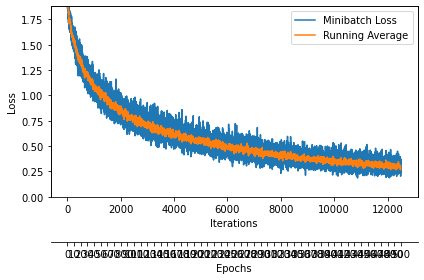

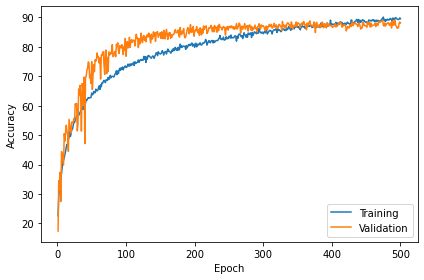

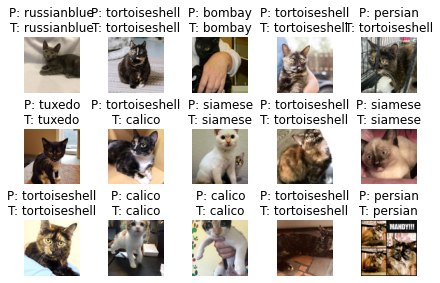

[[171   2   2   2   1   1   9   8]
 [  0 161   6   3   9   7   8   4]
 [  4  11 167   9   9  12   1   3]
 [  9   0   3 172   3   2   2   7]
 [  1   3   8   2 165   0   0   5]
 [  0   6   0   4   0 189   0   2]
 [  6  14   5   6   0   5 167   2]
 [  2   8   4   0   3   1   3 181]]


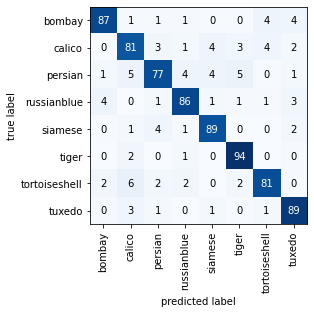

In [6]:
###################################
#**        Data Information     **#
###################################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')


#############################
#**         END           **#
#############################


# Getting count of each cat breed, should be close to 8*0.8*1000 initially..
train_data_distribution = get_cat_count(trainloader, 'training data')
# Getting count of each cat breed, should be close to 8*0.2*1000 initially..
test_data_distribution = get_cat_count(testloader, 'test data')

print(f'training data distribution - {train_data_distribution}')
print(f'test data distribution - {test_data_distribution}')

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=epochs,
                   iter_per_epoch=len(trainloader),
                   results_dir=None,
                   averaging_iterations=10)
plt.show()


plot_accuracy(train_acc_list=train_accuracy_list,
              test_acc_list=test_accuracy_list,
              results_dir=None)
plt.show()

net.cpu()
show_examples(model=net, data_loader=testloader, class_dict=cat_dict)

conf_matrix = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
print(conf_matrix)
plot_confusion_matrix(conf_matrix, class_names=cat_dict.values(), test_data_distribution=test_data_distribution)
plt.show()